# Predictive Analytics for Resource Allocation



This notebook implements predictive analytics for resource allocation using breast cancer diagnosis images. The goal is to predict issue priority (high/medium/low) based on image features.



## Data

- Images are in PNG format from benign and malignant folders.

- Labels: benign -> 'low' priority, malignant -> 'high' priority.



## Steps

1. Preprocess data: Load images, extract features using masks.

2. Train a Random Forest model.

3. Evaluate using accuracy and F1-score.

In [1]:
import os

import cv2

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import seaborn as sns



# Set style for plots

sns.set_style('whitegrid')

## Feature Extraction Function



Extract features from image and mask:

- Area of the mask (tumor area).

- Mean and std of pixel intensities in the masked region.

- Image dimensions and total pixels.

In [2]:
def extract_features(image_path, mask_path):

    # Load image and mask

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    

    if image is None or mask is None:

        return None

    

    # Ensure mask is binary

    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    

    # Calculate area of the mask (number of white pixels)

    area = np.sum(mask == 255)

    

    # Extract region of interest (ROI) from image using mask

    roi = cv2.bitwise_and(image, image, mask=mask)

    

    # Mean and std of pixel intensities in ROI

    roi_pixels = roi[mask == 255]

    if len(roi_pixels) == 0:

        mean_intensity = 0

        std_intensity = 0

    else:

        mean_intensity = np.mean(roi_pixels)

        std_intensity = np.std(roi_pixels)

    

    # Additional features: image dimensions, total pixels

    height, width = image.shape

    total_pixels = height * width

    

    return [area, mean_intensity, std_intensity, height, width, total_pixels]

## Load Data



Load images from benign and malignant folders, extract features, and assign labels.

In [3]:
def load_data(data_dir):

    data = []

    labels = []



    for label in ['benign', 'malignant']:

        folder = os.path.join(data_dir, label)

        # Check if folder exists before trying to list files

        if not os.path.exists(folder):

            print(f"Warning: Folder not found: {folder}")

            continue

        for file in os.listdir(folder):

            if file.endswith('.png') and not file.endswith('_mask.png'):

                image_path = os.path.join(folder, file)

                mask_path = os.path.join(folder, file.replace('.png', '_mask.png'))

                if os.path.exists(mask_path):

                    features = extract_features(image_path, mask_path)

                    if features is not None:

                        data.append(features)

                        labels.append(label)  # Store 'benign' or 'malignant'



    return np.array(data), np.array(labels)



# Data directory - construct path based on current working directory

# Since the notebook is in Task 3 folder, we need to check where we are

print(f"Current working directory: {os.getcwd()}")



# Try different possible paths (relative to where notebook runs from)

possible_paths = [

    'iuss-23-24-automatic-diagnosis-breast-cancer/training_set',  # If notebook runs from Task 3 folder

    'Task 3/iuss-23-24-automatic-diagnosis-breast-cancer/training_set',  # If notebook runs from project root

]



data_dir = None

for path in possible_paths:

    if os.path.exists(path):

        data_dir = path

        print(f"✓ Found data directory: {data_dir}")

        break



if data_dir is None:

    print("Error: Could not find data directory. Please check the path.")

    print("Expected structure: iuss-23-24-automatic-diagnosis-breast-cancer/training_set/{benign,malignant}")

    raise FileNotFoundError("Data directory not found. Please update the path in the cell above.")

else:

    # Load data

    X, y = load_data(data_dir)

    print(f"✓ Loaded {len(X)} samples with {X.shape[1]} features.")



    # Assign priorities based on new mapping

    priorities = []

    benign_indices = y == 'benign'

    benign_X = X[benign_indices]

    if len(benign_X) > 0:

        median_area = np.median(benign_X[:, 0])  # Area is first feature

        median_intensity = np.median(benign_X[:, 1])  # Mean Intensity is second feature

    else:

        median_area = 0

        median_intensity = 0



    for i, label in enumerate(y):

        if label == 'malignant':

            priorities.append('high')

        else:

            area = X[i, 0]

            intensity = X[i, 1]

            if area > median_area or intensity > median_intensity:

                priorities.append('medium')

            else:

                priorities.append('low')



    y = np.array(priorities)



    # Encode labels

    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()

    y_encoded = le.fit_transform(y)  # low=0, medium=1, high=2

    

    # Feature names

    feature_names = ['Area', 'Mean Intensity', 'Std Intensity', 'Height', 'Width', 'Total Pixels']

Current working directory: c:\Users\Peter Mwaura\Documents\AI FOR SOFTWARE ENG\AI-in-Software-Engineering-Assignment\Task 3
✓ Found data directory: iuss-23-24-automatic-diagnosis-breast-cancer/training_set
✓ Loaded 547 samples with 6 features.


## Data Exploration



Visualize feature distributions.

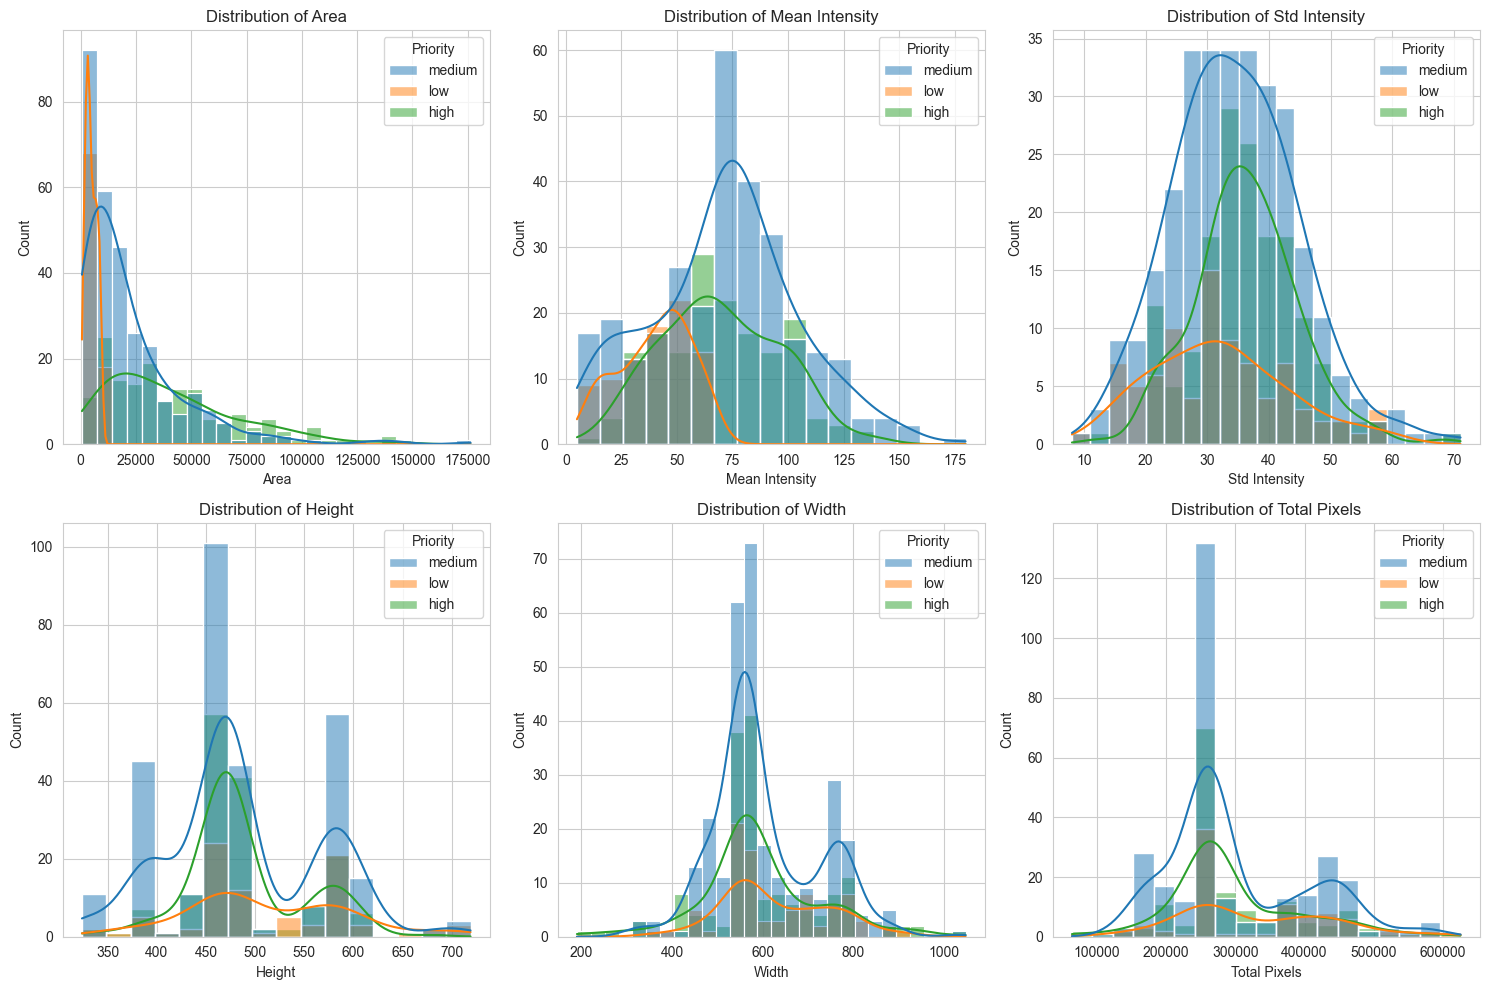

In [4]:
# Create DataFrame for visualization

df = pd.DataFrame(X, columns=feature_names)

df['Priority'] = y



# Plot distributions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, feature in enumerate(feature_names):

    ax = axes[i//3, i%3]

    sns.histplot(data=df, x=feature, hue='Priority', ax=ax, kde=True)

    ax.set_title(f'Distribution of {feature}')

plt.tight_layout()

plt.show()

## Data Splitting



Split into train (70%), validation (15%), test (15%).

In [5]:
# Split data

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 382, Val: 82, Test: 83


## Feature Scaling and Model Training



Scale features and train Random Forest.

In [6]:
# Scale features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

X_test_scaled = scaler.transform(X_test)



# Train Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_scaled, y_train)



print("Model trained.")

Model trained.


## Evaluation



Evaluate on validation and test sets.

Validation Accuracy: 0.8659
Validation F1-Score (Macro): 0.8728
Test Accuracy: 0.7108
Test F1-Score (Macro): 0.7348

Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.50      0.42      0.45        24
         low       1.00      1.00      1.00        13
      medium       0.72      0.78      0.75        46

    accuracy                           0.71        83
   macro avg       0.74      0.73      0.73        83
weighted avg       0.70      0.71      0.70        83



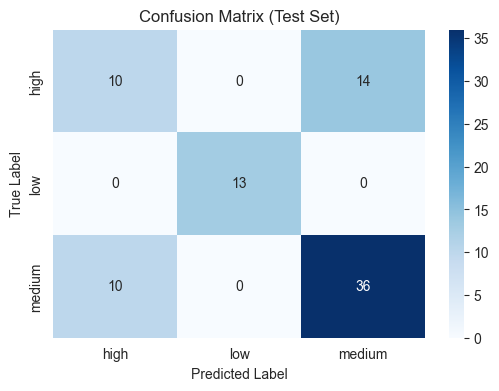

In [7]:
# Validation

y_val_pred = rf.predict(X_val_scaled)

val_accuracy = accuracy_score(y_val, y_val_pred)

val_f1 = f1_score(y_val, y_val_pred, average='macro')



print(f"Validation Accuracy: {val_accuracy:.4f}")

print(f"Validation F1-Score (Macro): {val_f1:.4f}")



# Test

y_test_pred = rf.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)

test_f1 = f1_score(y_test, y_test_pred, average='macro')



print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"Test F1-Score (Macro): {test_f1:.4f}")

print("\nClassification Report (Test Set):")

print(classification_report(y_test, y_test_pred, target_names=le.classes_))



# Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Confusion Matrix (Test Set)')

plt.ylabel('True Label')

plt.xlabel('Predicted Label')

plt.show()